# Statistical Leverage and CUR decomposition

* See: MMDS 11.4 CUR decomposition

In [233]:
import numpy as np
import pandas as pd

from scipy.linalg import svd, qr
from numpy.linalg import inv, matrix_power
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

In [111]:
M = np.matrix([[1, 1, 1, 0, 0],
               [3, 3, 3, 0, 0],
               [4, 4, 4, 0, 0],
               [5, 5, 5, 0, 0],
               [0, 0, 0, 4, 4],
               [0, 0, 0, 5, 5],
               [0, 0, 0, 2, 2]])

# QR decomposition

In [246]:
q, r, ranks = qr(M, mode='economic', pivoting=True)

### **Interpretation**
* ranks: represents good archetype columns from M: 0,3 with high R values on the diagonal, the rest is redundant

In [262]:
D = abs(np.diag(r))

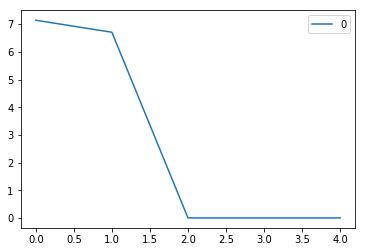

In [263]:
pd.DataFrame(D).plot()
plt.show()

In [264]:
ranks

array([0, 3, 4, 1, 2], dtype=int32)

In [265]:
pd.DataFrame(q)

,0,1,2,3,4
0,-0.140028,0.000000,0.403591,0.904161,-1.226133e-16
1,-0.420084,0.000000,-0.812021,0.297404,-5.397784e-02
2,-0.560112,-0.000000,0.198290,-0.175256,-7.498961e-01
3,-0.700140,-0.000000,0.247862,-0.219070,6.323036e-01
4,-0.000000,-0.596285,0.184971,-0.082566,-1.246048e-01
5,-0.000000,-0.745356,-0.184971,0.082566,1.246048e-01
6,-0.000000,-0.298142,0.092485,-0.041283,-6.230239e-02


In [266]:
pd.DataFrame(r)

,0,1,2,3,4
0,-7.141428,0.000000,0.000000e+00,-7.141428e+00,-7.141428e+00
1,0.000000,-6.708204,-6.708204e+00,0.000000e+00,0.000000e+00
2,0.000000,0.000000,-4.473739e-16,1.441319e-16,1.441319e-16
3,0.000000,0.000000,0.000000e+00,3.228974e-16,3.228974e-16
4,0.000000,0.000000,0.000000e+00,0.000000e+00,-5.126128e-32


Estimate of the eigenvalues

In [269]:
pd.DataFrame(D)

,0
0,7.141428e+00
1,6.708204e+00
2,4.473739e-16
3,3.228974e-16
4,5.126128e-32


# SVD

In [254]:
U, Sigma, V = svd(M, full_matrices=False)

In [258]:
pd.DataFrame(U)

,0,1,2,3,4
0,-0.140028,-4.616132e-34,1.384343e-17,-0.990148,-7.980818e-19
1,-0.420084,1.392322e-18,-4.175468e-02,0.059409,9.044950e-01
2,-0.560112,2.457964e-17,-7.371251e-01,0.079212,-3.022078e-01
3,-0.700140,-2.049911e-17,6.147529e-01,0.099015,-3.009308e-01
4,0.000000,-5.962848e-01,-1.849709e-01,0.000000,0.000000e+00
5,0.000000,-7.453560e-01,1.849709e-01,0.000000,0.000000e+00
6,0.000000,-2.981424e-01,-9.248543e-02,0.000000,0.000000e+00


Equivalently, SVD decomposition also produces 2 large eigenvalues, rest negligible

In [259]:
pd.DataFrame(Sigma)

,0
0,1.236932e+01
1,9.486833e+00
2,3.163411e-16
3,2.887176e-16
4,6.432645e-32


In [261]:
pd.DataFrame(V)

,0,1,2,3,4
0,-0.577350,-0.577350,-0.577350,0.000000,0.000000
1,-0.000000,-0.000000,-0.000000,-0.707107,-0.707107
2,0.000000,0.000000,0.000000,-0.707107,0.707107
3,0.816497,-0.408248,-0.408248,0.000000,0.000000
4,0.000000,-0.707107,0.707107,0.000000,0.000000


---

# Leverage scores

> Jiyan Yang, Oliver Rubel, Prabhat, Michael W. Mahoney, and Ben P. Bowen, Identifying Important Ions and Positions in Mass Spectrometry Imaging Data Using CUR Matrix Decompositions. Analytical Chemistry, 87(9), 4658-4666, 2015.

* see: https://github.com/chocjy/CUR-CX-MSI
* `Fro` = Frobenius / `Spe` = Spectral
* `fht` = Fast Hadamard Transform

## **Strategy**

If we can pull it off to compute the exact SVD of the ST, expression matrix we can use `compute_leverage_exact` to compute the column and row leverage scores without bothering with the Spectral or Frobenius norm approximate leverage scores.

In [270]:
def compute_leverage_exact(A, k, axis):    
    """ This function computes the column or row leverage scores of the input matrix.

    :param A: n-by-d matrix
    :param k: rank parameter, k <= min(n,d)
    :param axis: 0: compute row leverage scores; 1: compute column leverage scores.

    :returns: 1D array of leverage scores. If axis = 0, the length of lev is n.  otherwise, the length of lev is d.
    """
    
    U, D, V = svd(A, full_matrices=False)
    
    if axis == 0:
        lev = np.sum(U[:,:k]**2,axis=1)
    else:
        lev = np.sum(V[:k,:]**2,axis=0)

    p = lev/k

    return lev, p

In [274]:
compute_leverage_exact(M, k=3, axis=1)

(array([ 0.33333333,  0.33333333,  0.33333333,  1.        ,  1.        ]),
 array([ 0.11111111,  0.11111111,  0.11111111,  0.33333333,  0.33333333]))

---

In [162]:
def frobenius_norm(M, axis=0):
    m_pow_2 = np.power(M, 2)
    
    frobenius_norm_M = np.sum(np.sum(np.power(M, 2), axis=0), axis=1)[0, 0]
    
    return np.sum(m_pow_2, axis=axis) / frobenius_norm_M

In [81]:
frobenius_norm(M, axis=0)

matrix([[ 0.20987654,  0.20987654,  0.20987654,  0.18518519,  0.18518519]])

In [67]:
frobenius_norm(M, axis=1)

matrix([[ 0.01234568],
        [ 0.11111111],
        [ 0.19753086],
        [ 0.30864198],
        [ 0.13168724],
        [ 0.20576132],
        [ 0.03292181]])

In [77]:
np.sum(M, axis=0)

matrix([[13, 13, 13, 11, 11]])

* Test the effect of scaling on the leverage scores

In [78]:
M_scaled = np.matrix(StandardScaler().fit_transform(M))

/home/tmo/work/batiskav/installs/anaconda3/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


In [79]:
frobenius_norm(M_scaled, axis=0)

matrix([[ 0.2,  0.2,  0.2,  0.2,  0.2]])

In [80]:
frobenius_norm(M_scaled, axis=1)

matrix([[ 0.05205402],
        [ 0.06481998],
        [ 0.13822423],
        [ 0.25630934],
        [ 0.16217686],
        [ 0.24671294],
        [ 0.07970263]])


---

In [103]:
M2 = M[:, [0,4]]+1
M2

matrix([[2, 1],
        [4, 1],
        [5, 1],
        [6, 1],
        [1, 5],
        [1, 6],
        [1, 3]])

In [104]:
M2.T.dot(M2)

matrix([[84, 31],
        [31, 74]])

In [105]:
inv(M2.T.dot(M2))

matrix([[ 0.01408183, -0.00589914],
        [-0.00589914,  0.01598478]])

In [107]:
M2.dot(inv(M2.T.dot(M2))).dot(M2.T)

matrix([[ 0.04871551,  0.09324453,  0.11550904,  0.13777355,  0.04319696,
          0.04738344,  0.03482398],
        [ 0.09324453,  0.19410086,  0.24452902,  0.29495718,  0.01236917,
          0.00475737,  0.02759277],
        [ 0.11550904,  0.24452902,  0.30903901,  0.373549  , -0.00304472,
         -0.01655566,  0.02397716],
        [ 0.13777355,  0.29495718,  0.373549  ,  0.45214082, -0.01845861,
         -0.0378687 ,  0.02036156],
        [ 0.04319696,  0.01236917, -0.00304472, -0.01845861,  0.3547098 ,
          0.42873454,  0.20666032],
        [ 0.04738344,  0.00475737, -0.01655566, -0.0378687 ,  0.42873454,
          0.51874405,  0.24871551],
        [ 0.03482398,  0.02759277,  0.02397716,  0.02036156,  0.20666032,
          0.24871551,  0.12254995]])

In [22]:
np.power(M, 2)

matrix([[ 1,  4],
        [ 1,  9],
        [ 4, 16]])

In [23]:
def stat_lev(axis=0):
    

0.8